# ADS2002 - Catheter and Line Placement Project

## Project Background

The Catheter and Line position project was a Kaggle challenge created by the Royal Australian and NZ College of Radiologists (RANZCR) in an attempt to help clincians to be able to detect malpositioned catheters and lines early in order to save lives.

### OUR OBJECTIVE
The objective of this project is to use machine learning to train and test a model on 40,000 images to categorize whether a catheter or line has been poorly placed.

### WHAT IS A CATHETER?

A catheter is a thin tube made from medical grade materials serving a broad range of functions. Catheters are medical devices that can be inserted into the body to treat diseases or as an aid when performing surgical procedures.

The most common catheter is that inserted into the bladder. This allows urine to drain freely. In this project we are not looking at this catheter but rather 4 other types:

1. Endotracheal (inserted between the vocal cords and through the trachea to provide oxygen and inhaled gases to the lungs)
2. Nasogastric (inserted through the nose into the stomach. Used to carry food and medicine directly to the stomach)
3. Central Venous (inserted into a large vein in the neck, chest, groin or arm. Typcially used to administer medications over a long period of time as well as directly measure blood pressume)
4. Swan Ganz (inserted into the right of the heart to monitor heart function including blood flow and pressures in and around the heart)

Hospital patients have catheters and lines inserted during the course of their admission and serious complications can arise if they are positioned incorrectly. Millions of COVID-19 patients need tubes and lines inserted with a reported 3% of cases inserted incorrectly.

Chest Radiographs are the gold standard to confirm whether a line or tube is placed correctly. A physician must manually check these chest x-rays to verify the optimal position. This process can be slow and leaves room for human error.

In this project we want to use Deep learning algorithms to automatically detect malpositioned catheters and lines. These will alert clincians immediately and they can reposition or remove them before complications develop

### FILES GIVEN

- **train.csv** - contains images IDs, binary labels and patient IDs
- **train_annotations.csv** - provides annotations for each image in the training set. Will be able to plot where the line or catheter is.
- **test** - Folder with all test images
- **train** - Folder with all train images (IDs same as IDs in train dataset)
- TFRecords - Tensor Flow Records (way of storing a sequence of binary records)



## 1. Mount to Drive -> will allow access to data set



In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ADS2002-Project-CatheterPlacement

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ADS2002-Project-CatheterPlacement


In [4]:
!ls -lt

ls: ranzcr-clip-catheter-line-classification: No such file or directory
total 207
drwx------ 3 root root   4096 Aug 19 00:21  Data
-rw------- 1 root root    182 Aug 18 06:23 'ADS2002 - Catheter Placement.gdoc'
-rw------- 1 root root 205295 Aug 18 00:49  CatheterPlacementADS2002.pdf
-rw------- 1 root root   1783 Aug 11 06:17  mtcars.csv
lrw------- 1 root root      0 Aug 11 05:22  ranzcr-clip-catheter-line-classification -> /content/drive/.shortcut-targets-by-id/1nr3dkndFZpGTbj671CSST0ofESPOncpx/ranzcr-clip-catheter-line-classification


In [5]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from PIL import Image
import ast

### 2. Data Set Exploration

In [6]:
train = pd.read_csv('Data/train.csv')
train.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


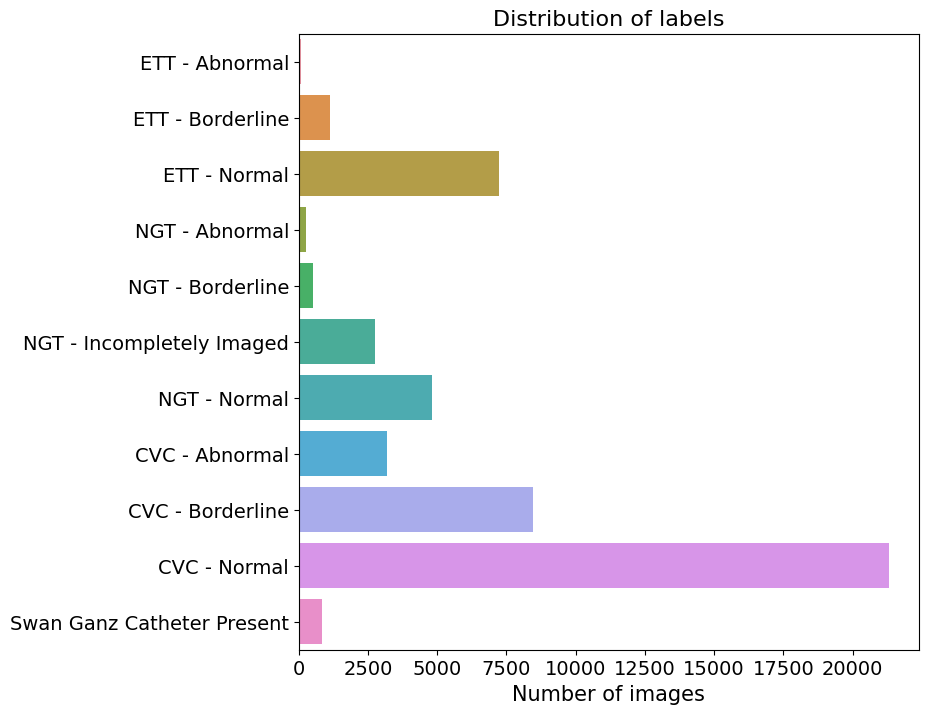

In [7]:
plt.figure(figsize=(8, 8))
df_tmp = train.iloc[:, 1:-1].sum()



sns.barplot(x=df_tmp.values, y=df_tmp.index)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Number of images", fontsize=15)
plt.title("Distribution of labels", fontsize=16);

### COLUMNS

- **StudyInstanceUID** - unique ID for each image
- **ETT - Abnormal** - endotracheal tube placement abnormal
- **ETT - Borderline** - endotracheal tube placement borderline abnormal
- **ETT - Normal** - endotracheal tube placement normal
- **NGT - Abnormal** - nasogastric tube placement abnormal
- **NGT - Borderline** - nasogastric tube placement borderline abnormal
- **NGT - Incompletely Imaged** - nasogastric tube placement inconclusive due to imaging
- **NGT - Normal** - nasogastric tube placement borderline normal
- **CVC - Abnormal** - central venous catheter placement abnormal
- **CVC - Borderline** - central venous catheter placement borderline abnormal
- **CVC - Normal** - central venous catheter placement normal
- **Swan Ganz Catheter Present**
- **PatientID** - unique ID for each patient in the dataset

In [8]:
print("Number of unique patients: ", train["PatientID"].unique().shape[0])

Number of unique patients:  3255


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30083 entries, 0 to 30082
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   StudyInstanceUID            30083 non-null  object
 1   ETT - Abnormal              30083 non-null  int64 
 2   ETT - Borderline            30083 non-null  int64 
 3   ETT - Normal                30083 non-null  int64 
 4   NGT - Abnormal              30083 non-null  int64 
 5   NGT - Borderline            30083 non-null  int64 
 6   NGT - Incompletely Imaged   30083 non-null  int64 
 7   NGT - Normal                30083 non-null  int64 
 8   CVC - Abnormal              30083 non-null  int64 
 9   CVC - Borderline            30083 non-null  int64 
 10  CVC - Normal                30083 non-null  int64 
 11  Swan Ganz Catheter Present  30083 non-null  int64 
 12  PatientID                   30083 non-null  object
dtypes: int64(11), object(2)
memory usage: 3.0+ MB


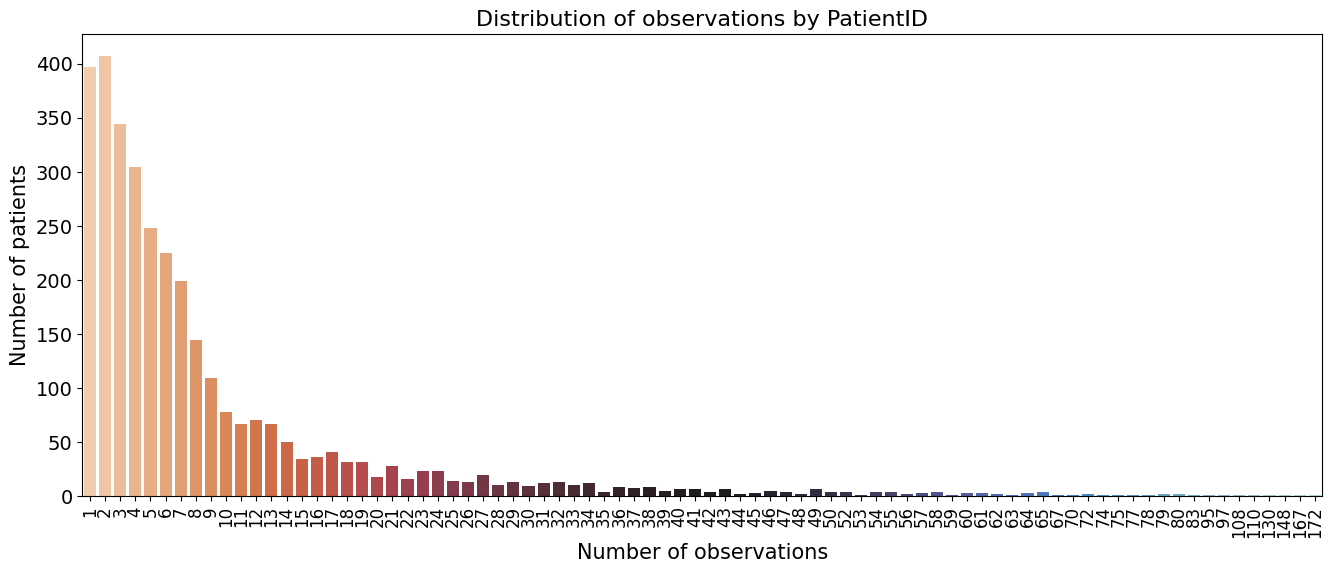

In [10]:
plt.figure(figsize=(16, 6))
df_tmp = train["PatientID"].value_counts()
sns.countplot(x=df_tmp.values, palette='icefire_r')
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=14)
plt.xlabel("Number of observations", fontsize=15)
plt.ylabel("Number of patients", fontsize=15)
plt.title("Distribution of observations by PatientID", fontsize=16);

### Annotations Dataset

In [11]:
annot = pd.read_csv('Data/train_annotations.csv')
annot.head()


,StudyInstanceUID,label,data
0,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1487, 1279], [1477, 1168], [1472, 1052], [14..."
1,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2..."
2,1.2.826.0.1.3680043.8.498.72921907356394389969...,CVC - Borderline,"[[801, 1207], [812, 1112], [823, 1023], [842, ..."
3,1.2.826.0.1.3680043.8.498.11697104485452001927...,CVC - Normal,"[[1366, 961], [1411, 861], [1453, 751], [1508,..."
4,1.2.826.0.1.3680043.8.498.87704688663091069148...,NGT - Normal,"[[1862, 14], [1845, 293], [1801, 869], [1716, ..."


In [12]:
annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17999 entries, 0 to 17998
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   StudyInstanceUID  17999 non-null  object
 1   label             17999 non-null  object
 2   data              17999 non-null  object
dtypes: object(3)
memory usage: 422.0+ KB


In [27]:
# Combine the train and annotations dataset

trainWannot = pd.merge(train, annot, on="StudyInstanceUID")


trainWannot.to_csv('Data/trainWithAnnotations.csv')
trainWannot.shape

(17999, 15)

In [22]:
patients = trainWannot['PatientID'].value_counts()
patients = pd.DataFrame(patients)
patients = patients.rename(columns={'PatientID': 'Image Count'})

nice = patients[patients['Image Count'] == 4]
nice

,Image Count
9823f0850,4
7459ad34f,4
b1123524f,4
5b0c17a48,4
e4e273eb2,4
...,...
d99956b03,4
f6cbde7ae,4
0c953296c,4
7192404d8,4


<br>
<br>
<br>





<br>

<br>




<br>

In [15]:
def plot_annotations(ind):
  row = annot.iloc[ind]
  image_path = "Data/train/" + row['StudyInstanceUID'] + ".jpg"
  label = row['label']
  data = np.array(ast.literal_eval(row["data"]))

  plt.figure(figsize=(10,5))
  image = Image.open(image_path)
  plt.subplot(1,2,1)
  plt.imshow(image)
  plt.subplot(1,2,2)
  plt.imshow(image)
  plt.scatter(data[:,0], data[:,1], color='lightsteelblue')

  plt.suptitle(label)

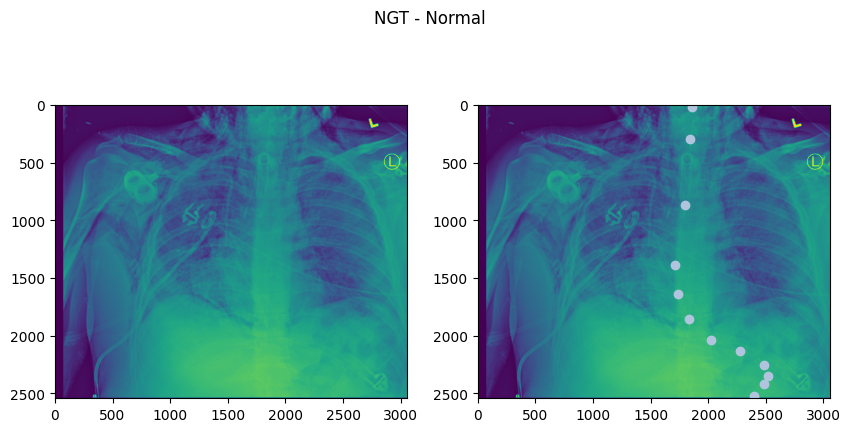

In [16]:
plot_annotations(4)

In [17]:
# Function to make multiple annotations on 1 image

def multiple_annotations(img_id):

  plt.figure(figsize=(8,8))

  image = Image.open("Data/train/" + img_id + ".jpg")
  plt.imshow(image)

  patient = annot.loc[annot["StudyInstanceUID"] == img_id]

  if patient.shape[0]:
    labels = patient['label'].values.tolist()
    catheters = patient['data'].apply(ast.literal_eval).values.tolist()

    for catheter, label in zip(catheters, labels):
      catheter = np.asarray(catheter)
      plt.scatter(catheter[:, 0], catheter[:,1], s=40, label=label)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, prop={'size': 20})

  plt.tick_params(axis="x", labelsize=15)
  plt.tick_params(axis="y", labelsize=15)

  plt.show()

In [18]:
# Function to find all the x-ray images for 1 patient

def find_patient_files(patientID):
  patient = trainWannot[trainWannot['PatientID'] == patientID]

  images = patient['StudyInstanceUID'].tolist()
  images = list(set(images))
  return images

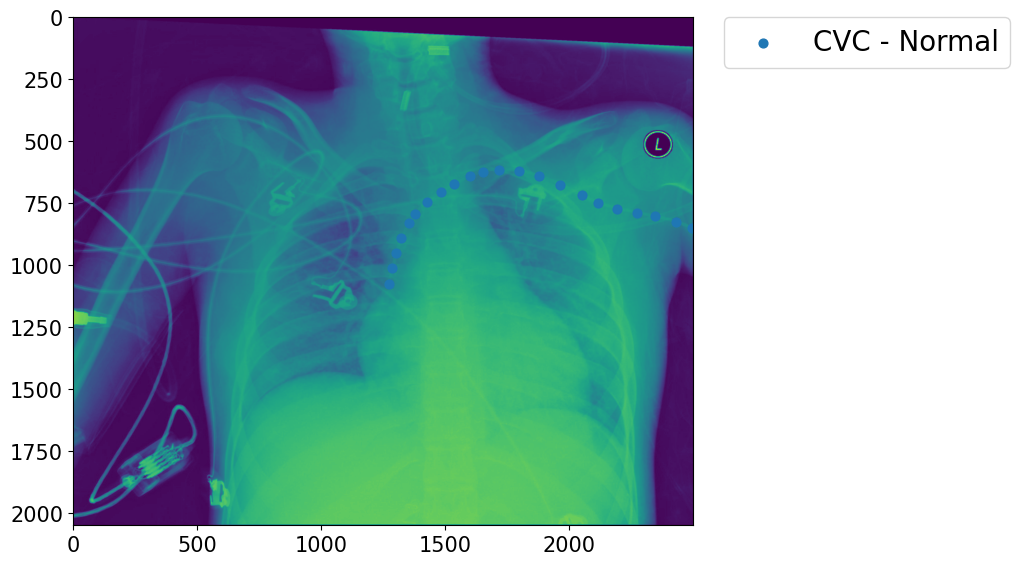

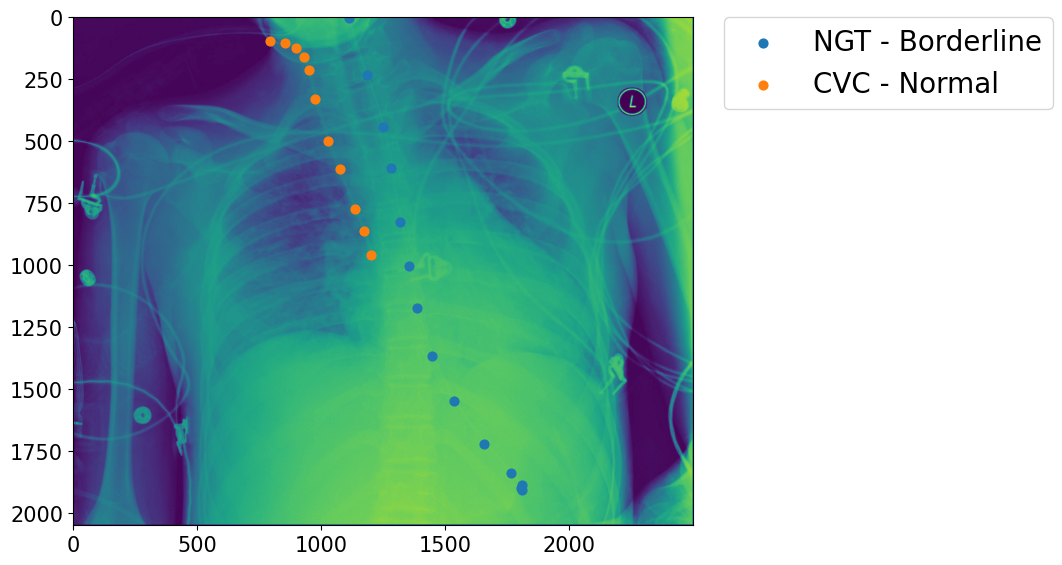

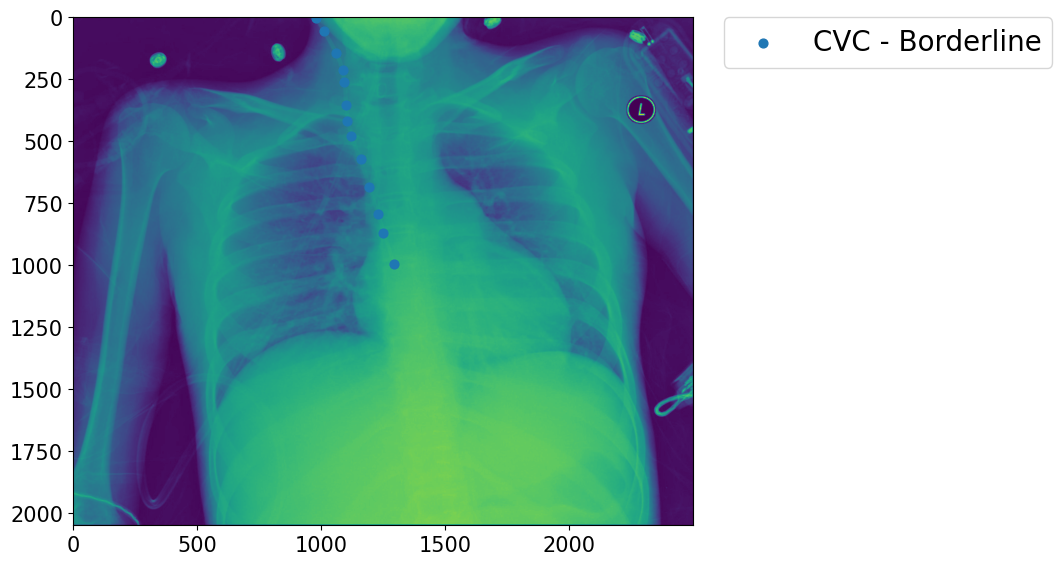

In [20]:
image_ids = find_patient_files('7459ad34f')


for id in image_ids:
  multiple_annotations(id)
